<a href="https://colab.research.google.com/github/olszewskip/Sign_Language/blob/master/sign_language_DL_with_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiclass classification of images with convolutional networks
The data comes from this repository:
https://github.com/ardamavi/Sign-Language-Digits-Dataset

The images are of various individuals' right hands presenting a single digit in a sign language. A sample is displayed below.

### Notable:
* We compare various  approaches and hyperparameters using cross-validation in a basic grid-search.
* This includes using/not-using data augmentation,
* and tuning of the batch size and learning rate.
* We also compare the performance of a simple (sequential, not very deep) model against MobileNet V2 from Google.

### More details:
* The test data in each fold is never augmented. The folds are obtained by shuffling followed by a stratified split into 5 chunks.
* Definition of the model includes: its architecture, size of the images, data_augmentation procedure (or lack thereof), batch size, optimizer and its learning rate, loss function, fraction of the train-data that is put aside for early-stopping, patience (in epochs) of the early-stopping, maximal number of epochs, the network's initial weights (or the algorithm for their random initialization).
* Only some of the above are examined below. But the procedure is straightforward enough to enable tuning any of those options. 
* The MobileNet V2 is initialized with weights trained on 'Imagenet' (if the Keras documentation is to be believed, that is), it has some simple arbitrary dense layers put on top, to match the dense layers from our simple sequential model, and all the weights are retrained from the start (no freezing of the weights).

### Summary of the results:
* See the README file


---
Google-Colab specific biolerplate and imports

In [0]:
from tensorflow import test
test.gpu_device_name()

'/device:GPU:0'

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option("display.precision", 4)

import gc

from sklearn.model_selection import StratifiedKFold

import keras
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization, GlobalMaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.mobilenet_v2 import MobileNetV2

import tensorflow
from tensorflow.logging import set_verbosity, ERROR
set_verbosity(ERROR)

Using TensorFlow backend.


In [0]:
keras.__version__, tensorflow.__version__

('2.2.4', '1.14.0-rc1')

---
Define path to the directory where the images are.

The latter are actually grouped into subdirectories specific for each label,
ie. "0", "1", ..., "9" in this case.

In [0]:
working_dir = os.path.join("/content/gdrive/My Drive/Colab Notebooks/Sign_Language/")
github_data_dir = os.path.join(working_dir, "data/ardamavi/Dataset")

os.listdir(github_data_dir)

['0', '5', '3', '6', '2', '9', '4', '7', '8', '1']

---
Examine how many images are in each subdirectory.

Remember the total count.

In [0]:
def examine_file_counts(path):
  
  total_count = 0
  
  for class_ in os.listdir(path):
    from_dir = os.path.join(path, class_)
    whole_count = len(os.listdir(from_dir))
    total_count += whole_count
    print(f"class {class_}: {whole_count} photos")

  print(f"{total_count} photos in total")
  return total_count

total_count = examine_file_counts(github_data_dir)

class 0: 205 photos
class 5: 207 photos
class 3: 206 photos
class 6: 207 photos
class 2: 206 photos
class 9: 204 photos
class 4: 207 photos
class 7: 206 photos
class 8: 208 photos
class 1: 206 photos
2062 photos in total


---
This is not a huge dataset.
We can load all the images into memory.

Still, it is convenient to use the generator provided
by keras to:
* automatically pair images with labels,
* one-hot-encode the labels,
* and to shufle.

It can also serve to resize the images away from the
original resolution, which is 100 x 100.

In [0]:
def get_data_from_dir(img_dim,
                      dir_=github_data_dir,
                      total_count=total_count,
                      seed=123):
  data_gen =\
    ImageDataGenerator(rescale=1/255).flow_from_directory(
      dir_,
      target_size = (img_dim, img_dim),
      batch_size = total_count,
      shuffle=True,
      class_mode='sparse',
      seed=seed)
  return next(data_gen)

---
Plot ten random images to get a feel for how the look.

Found 2062 images belonging to 10 classes.


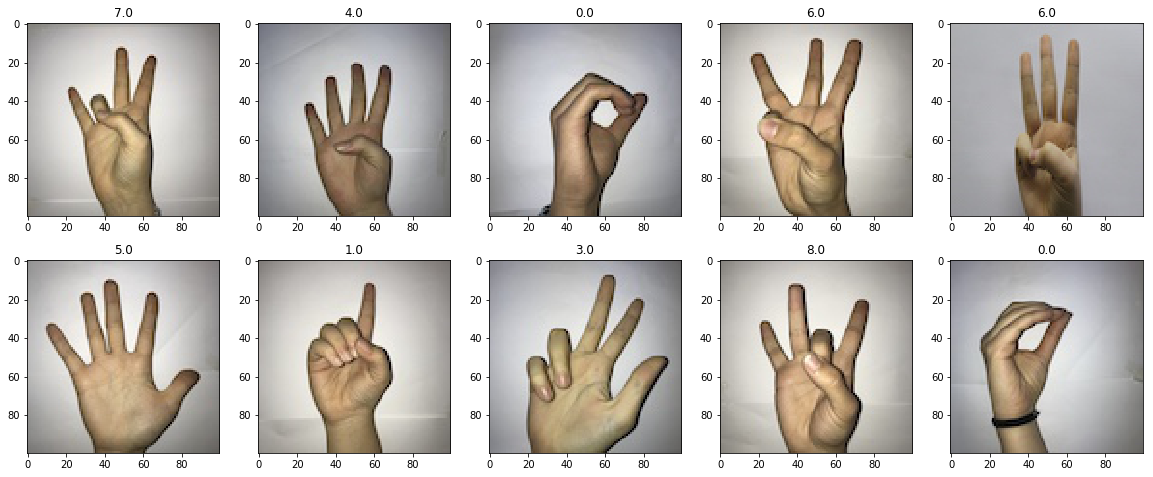

In [0]:
X, y = get_data_from_dir(img_dim=100)

samples = []
for _ in range(10):
  idx = np.random.choice(total_count)
  samples.append((X[idx], y[idx]))
  
fig, axes = plt.subplots(2, 5, figsize=(20,8))
for (img, label), ax in zip(samples, axes.ravel()):
  ax.title.set_text(str(label))
  ax.imshow(img)

---
Define a function, that  returns a function that returns an uncompiled model. The compilcatoin is due to the need to parametrized those model producing functions with image dimensions.

In [0]:
def get_simple_seq(img_dim):
  
  def simple_seq():
    activ = 'elu'
    inputs = Input(shape = (img_dim, img_dim, 3))
    x = Conv2D(32, (3,3), strides=(1,1), padding='same', activation=activ)(inputs)
    x = MaxPooling2D((3,3))(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3,3), strides=(1,1), padding='same', activation=activ)(x)
    x = MaxPooling2D((3,3))(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3,3), strides=(1,1), padding='same', activation=activ)(x)
    x = MaxPooling2D((3,3))(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(rate=0.3)(x)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(10, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model
  
  return simple_seq

Also, define a simple utility function for counting number of trainble weights in a model.

In [0]:
def count_trainable(model):
  """Utility function"""
  results = len(model.layers),\
            int(np.sum([K.count_params(p) for p in set(model.trainable_weights)]))
  del model
  print("number of layers , number of parameters")
  print(results)

In [0]:
count_trainable(get_simple_seq(100)())

number of layers , number of parameters
(15, 457226)


---
Use startified k-fold cross-validation (say with k=5).

Use a single function to perform:
* splitting of the data into folds
* fitting to (k-1)/k fraction of the data and testing on the other 1/k
* return average accuracy and some measure of its variance

The function accepts some hyperparameters as its arguments.

In [0]:
def get_accuracy_in_cv(model_producing_function,
                       X, y,                
                       batch_size,
                       learning_rate,
                       augmentation_kwargs,
                       VAL_SPLIT = 0.1,
                       PATIENCE = 10,
                       N_SPLITS = 5):
  
  cv_results = []

  skf5 = StratifiedKFold(n_splits=N_SPLITS, shuffle=True)
  folds = skf5.get_n_splits()

  for fold_index, (train_index, test_index) in enumerate(skf5.split(X, y)):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    augment_data_gen = ImageDataGenerator(\
                          validation_split=VAL_SPLIT,
                          **augmentation_kwargs                
                                         )

    train_data_gen = augment_data_gen.flow(X_train, y_train,
                                           batch_size=batch_size,
                                           subset='training',
                                           )

    val_data_gen = augment_data_gen.flow(X_train, y_train,
                                         batch_size=batch_size,
                                         subset='validation',
                                         )


    model = model_producing_function()
    model.compile(loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'],
                  optimizer=Adam(lr=learning_rate))

    callbacks = [EarlyStopping(monitor='val_acc',
                               patience=PATIENCE,
                               verbose=0,
                               restore_best_weights=True)]

    model.fit_generator(train_data_gen,
                        steps_per_epoch = int(np.ceil((1-VAL_SPLIT) * len(X_train) / batch_size)),
                        validation_data = val_data_gen,
                        validation_steps = int(np.ceil(VAL_SPLIT * len(X_train) / batch_size)),
                        epochs=50,
                        callbacks=callbacks,
                        verbose=0
                       )
    
    fold_loss, fold_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Fold {fold_index + 1}/{folds}: {fold_acc:.4f} acc.")
    cv_results.append(fold_acc)
    
    del model
    K.clear_session()
    gc.collect()
  
  cv_mean, cv_delta = np.mean(cv_results), 2*np.std(cv_results)
  print(f"Average accuracy: {cv_mean:.4f} +- {cv_delta:.4f}")
  
  return cv_mean, cv_delta

---
Define a grid of hyperparameters. Each combination will be passed to the cross-validating function.

In [0]:
batch_sizes = [32, 64, 128]

learning_rates = [0.0001, 0.0004, 0.001]


augmentation_kwargs_options = [\
  ("no", dict(rotation_range=0,
                height_shift_range=0.0,
                width_shift_range=0.0,
                zoom_range=0.0)),
  ("yes", dict(rotation_range=20,
                height_shift_range=0.1,
                width_shift_range=0.1,
                zoom_range=0.1))
                              ]

---
Perform the grid search with cross-validation for our simple sequential model.

In [0]:
print("Simple sequential model")
IMG_DIM = 100

X, y = get_data_from_dir(img_dim=IMG_DIM)

simple_seq_grid_cv = []

for batch_size in batch_sizes:
  for learning_rate in learning_rates:
    for augmentation_description, augmentation_kwargs in augmentation_kwargs_options:
      
      print(f"Batch size = {batch_size}, lr = {learning_rate}, augmentation: {augmentation_description}")
      
      cv_mean, cv_delta =\
      get_accuracy_in_cv(get_simple_seq(img_dim=IMG_DIM),
                         X, y,
                         batch_size=batch_size,
                         learning_rate=learning_rate,
                         augmentation_kwargs=augmentation_kwargs)
      
      cv_result = dict(batch_size=batch_size,
                       learning_rate=learning_rate,
                       augmentation=augmentation_description,
                       mean_accuracy=cv_mean,
                       acc_std_x2=cv_delta)
      
      simple_seq_grid_cv.append(cv_result)
    

Simple sequential model
Found 2062 images belonging to 10 classes.
Batch size = 32, lr = 0.0001, augmentation: no
Fold 1/5: 0.9593 acc.
Fold 2/5: 0.9614 acc.
Fold 3/5: 0.9221 acc.
Fold 4/5: 0.9634 acc.
Fold 5/5: 0.9658 acc.
Average accuracy: 0.9544 +- 0.0325
Batch size = 32, lr = 0.0001, augmentation: yes
Fold 1/5: 0.9617 acc.
Fold 2/5: 0.9952 acc.
Fold 3/5: 0.9684 acc.
Fold 4/5: 0.9878 acc.
Fold 5/5: 0.9609 acc.
Average accuracy: 0.9748 +- 0.0281
Batch size = 32, lr = 0.0004, augmentation: no
Fold 1/5: 0.9809 acc.
Fold 2/5: 0.9565 acc.
Fold 3/5: 0.9708 acc.
Fold 4/5: 0.9634 acc.
Fold 5/5: 0.9364 acc.
Average accuracy: 0.9616 +- 0.0299
Batch size = 32, lr = 0.0004, augmentation: yes
Fold 1/5: 0.9904 acc.
Fold 2/5: 0.9734 acc.
Fold 3/5: 0.9927 acc.
Fold 4/5: 0.9927 acc.
Fold 5/5: 0.9731 acc.
Average accuracy: 0.9845 +- 0.0184
Batch size = 32, lr = 0.001, augmentation: no
Fold 1/5: 0.9665 acc.
Fold 2/5: 0.9734 acc.
Fold 3/5: 0.9732 acc.
Fold 4/5: 0.9659 acc.
Fold 5/5: 0.9682 acc.
Average

In [0]:
print("Simple sequential model")
ordered_columns = ['batch_size', 'learning_rate', 'augmentation', 'mean_accuracy', 'acc_std_x2']
pd.DataFrame(simple_seq_grid_cv)[ordered_columns].sort_values(by='mean_accuracy', ascending=False)

Simple sequential model


,batch_size,learning_rate,augmentation,mean_accuracy,acc_std_x2
9,64,0.0004,yes,0.9884,0.0077
3,32,0.0004,yes,0.9845,0.0184
5,32,0.0010,yes,0.9811,0.0227
7,64,0.0001,yes,0.9801,0.0220
1,32,0.0001,yes,0.9748,0.0281
15,128,0.0004,yes,0.9739,0.0241
13,128,0.0001,yes,0.9738,0.0188
17,128,0.0010,yes,0.9710,0.0415
4,32,0.0010,no,0.9694,0.0065
16,128,0.0010,no,0.9650,0.0179


---
Repeat the same grid-search as above but with a more sophisticated convolutional network. One that can be imported from keras. Let's choose MobileNetV2.

In [0]:
def get_mobilenet(img_dim):
  
  def mobilenet():
    MobileNetV2_ = MobileNetV2(include_top=False,
                               weights='imagenet',
                               input_shape=(img_dim, img_dim, 3))
      
    x = MobileNetV2_.output
    x = GlobalMaxPooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(rate=0.3)(x)
    x = Dense(256, activation='relu')(x)
    output = Dense(10, activation='softmax')(x)
    model = Model(inputs=MobileNetV2_.input, outputs=output)
    return model
  
  return mobilenet

In [0]:
count_trainable(get_mobilenet(128)())

9412608/9406464 [==============================] - 0s 0us/step
number of layers , number of parameters
(160, 2620170)


In [0]:
print("MobileNet V2")
IMG_DIM = 128

X, y = get_data_from_dir(img_dim=IMG_DIM)

mobilenet_grid_cv = []

for batch_size in batch_sizes:
  for learning_rate in learning_rates:
    for augmentation_description, augmentation_kwargs in augmentation_kwargs_options:
      
      print(f"Batch size = {batch_size}, lr = {learning_rate}, augmentation: {augmentation_description}")
      
      cv_mean, cv_delta =\
      get_accuracy_in_cv(get_mobilenet(img_dim=IMG_DIM),
                         X, y,
                         batch_size=batch_size,
                         learning_rate=learning_rate,
                         augmentation_kwargs=augmentation_kwargs)
      
      cv_result = dict(batch_size=batch_size,
                       learning_rate=learning_rate,
                       augmentation=augmentation_description,
                       mean_accuracy=cv_mean,
                       acc_std_x2=cv_delta)
      
      mobilenet_grid_cv.append(cv_result)
    

MobileNet V2
Found 2062 images belonging to 10 classes.
Batch size = 32, lr = 0.0001, augmentation: no
Fold 1/5: 0.9474 acc.
Fold 2/5: 0.9614 acc.
Fold 3/5: 0.9684 acc.
Fold 4/5: 0.9268 acc.
Fold 5/5: 0.9682 acc.
Average accuracy: 0.9544 +- 0.0315
Batch size = 32, lr = 0.0001, augmentation: yes
Fold 1/5: 0.9928 acc.
Fold 2/5: 0.9686 acc.
Fold 3/5: 0.9781 acc.
Fold 4/5: 0.9585 acc.
Fold 5/5: 0.9756 acc.
Average accuracy: 0.9747 +- 0.0226
Batch size = 32, lr = 0.0004, augmentation: no
Fold 1/5: 0.9737 acc.
Fold 2/5: 0.9638 acc.
Fold 3/5: 0.9830 acc.
Fold 4/5: 0.9683 acc.
Fold 5/5: 0.9804 acc.
Average accuracy: 0.9738 +- 0.0144
Batch size = 32, lr = 0.0004, augmentation: yes
Fold 1/5: 0.9833 acc.
Fold 2/5: 0.9952 acc.
Fold 3/5: 0.9781 acc.
Fold 4/5: 0.9805 acc.
Fold 5/5: 0.9853 acc.
Average accuracy: 0.9845 +- 0.0118
Batch size = 32, lr = 0.001, augmentation: no
Fold 1/5: 0.8852 acc.
Fold 2/5: 0.9396 acc.
Fold 3/5: 0.9781 acc.
Fold 4/5: 0.9463 acc.
Fold 5/5: 0.9878 acc.
Average accuracy: 

In [20]:
print("Mobilenet V2")
ordered_columns = ['batch_size', 'learning_rate', 'augmentation', 'mean_accuracy', 'acc_std_x2']
pd.DataFrame(mobilenet_grid_cv)[ordered_columns].sort_values(by='mean_accuracy', ascending=False)

Mobilenet V2


,batch_size,learning_rate,augmentation,mean_accuracy,acc_std_x2
3,32,0.0004,yes,0.9845,0.0118
15,128,0.0004,yes,0.9811,0.0140
7,64,0.0001,yes,0.9811,0.0132
17,128,0.0010,yes,0.9802,0.0166
16,128,0.0010,no,0.9777,0.0174
9,64,0.0004,yes,0.9772,0.0143
1,32,0.0001,yes,0.9747,0.0226
11,64,0.0010,yes,0.9738,0.0215
2,32,0.0004,no,0.9738,0.0144
10,64,0.0010,no,0.9719,0.0448


---
### End